In [11]:
from min30_zeroInf_negative_Binomial import *
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
from PIL import Image
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot
from Utils.eval import *
from tensorflow.keras.optimizers import Adam
import keras.backend.tensorflow_backend
from keras.backend import clear_session
from tensorflow.keras.models import Model,Sequential

In [2]:
source_model,modelpath,train,test = getModel(False)
source_model.summary()
predictions = source_model.layers[-2].output
model = Model(inputs=source_model.inputs, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 5)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 20)   920         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 96, 96, 20)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 48, 20)   0           activation[0][0]                 
______________________________________________________________________________________________

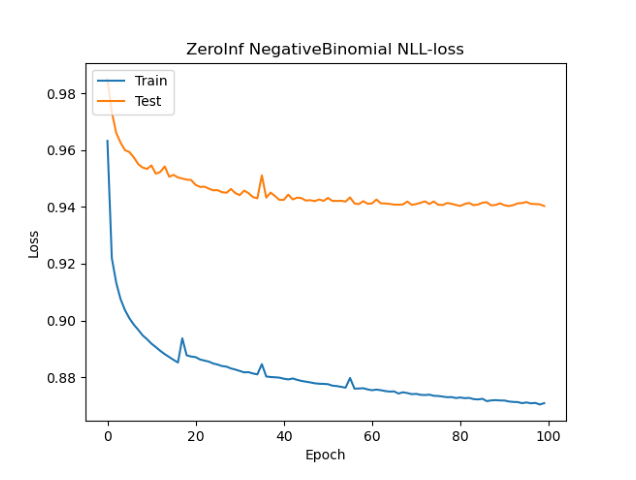

In [3]:
history_path = os.path.join(modelpath,MODELNAME+"_history.png")
figure(num=None, figsize=(10, 30), dpi=80, facecolor='w', edgecolor='k')
loss = np.array(Image.open(history_path))
plt.imshow(loss)
plt.axis('off')
plt.show()
y_transform = [cutOut([16,80,16,80])]

In [4]:
history_path = os.path.join(modelpath,MODELNAME+"_history")
laststate = getBestState(modelpath,history_path)
epoch = laststate["epoch"]
model.load_weights(laststate["modelpath"])
test.setWiggle_off()

In [5]:
def getFreshSet(batch_size=1):
    #x_transform = [Normalize(0.007742631458799244, 0.015872015890555563 )]
    
    train,test = getData(batch_size,
                         DIMENSION,CHANNELS,
                         timeToPred=30,
                         y_transform=y_transform)
    return train,test

In [6]:
from Models.Distributions import ZeroInflated_Binomial
pred = None
label = None
pred = 20
#test.on_epoch_end()
mean = []
stdev = []
label = []
predictions = []
train,test = getFreshSet(50)
test.on_epoch_end()
test.setWiggle_off()
atm = []
for x,y in test:
    for i in range(BATCH_SIZE):
        if y[i,:,:,:].max() >= 0:
            pred = model(np.array([x[i,:,:,:]]))
            pred = ZeroInflated_Binomial()(pred)
            mean.append(pred.mean())
            stdev.append(pred.stddev())
            label.append(y[i,:,:,:])
            predictions.append((pred,y[i:,:,:]))
            atm.append(x[i,:,:,-1:])
            if len(label) == 20:
                break
        break
    if len(label) == 20:
                break

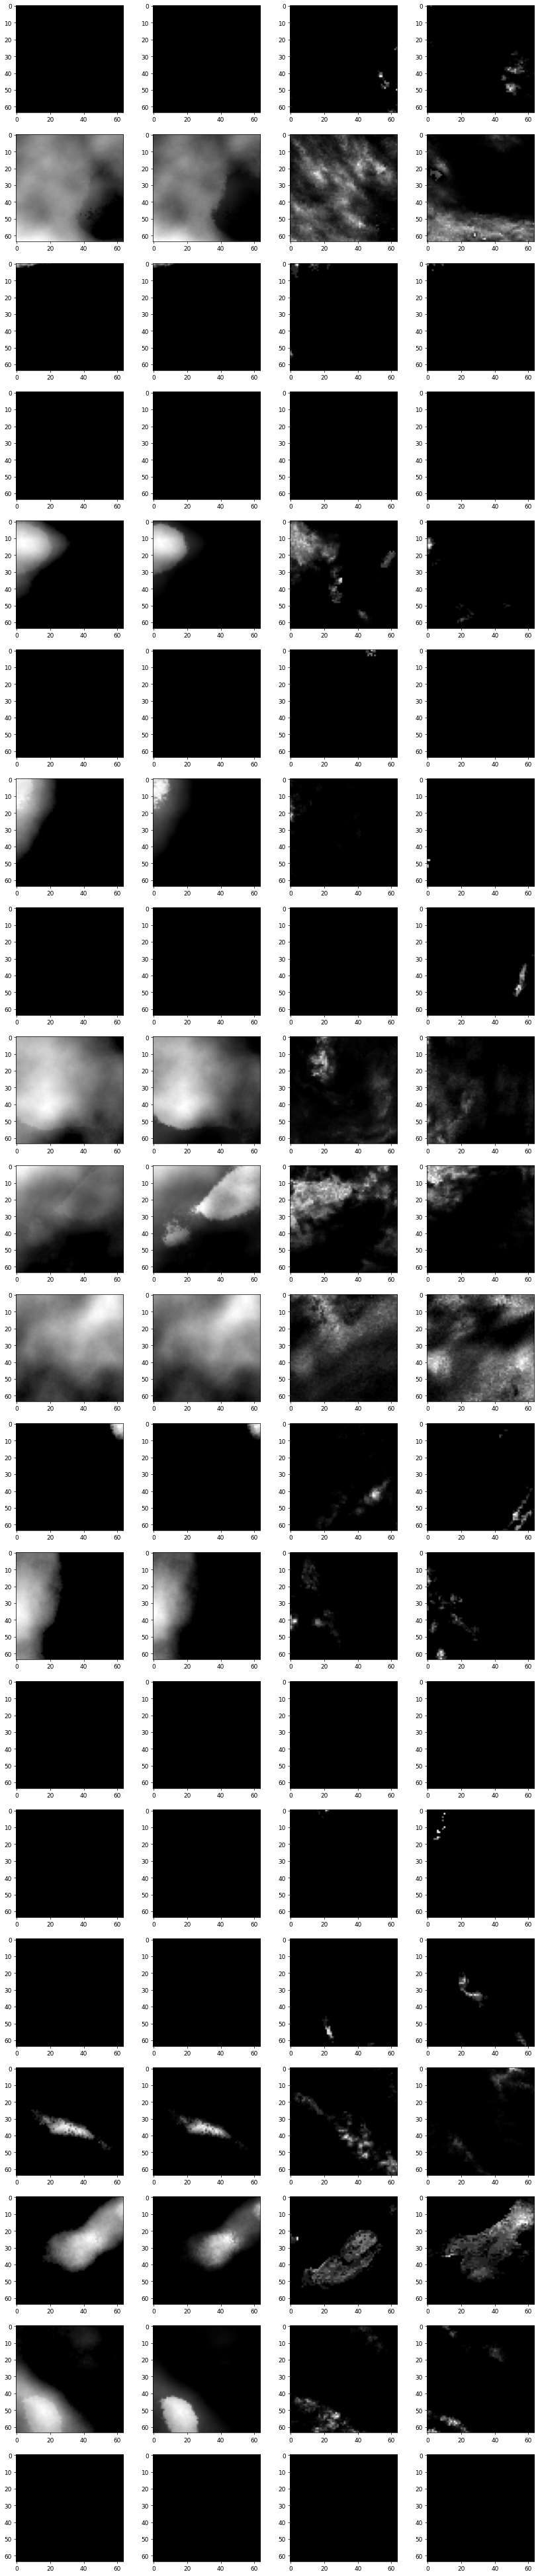

In [7]:
fig, axes = plt.subplots(20, 4, figsize=(16,8*10),dpi=64)
#fig.set_title(["mean","stdev","label"])
for batch,img in enumerate(mean):
    if batch == 20:
        break
    axes[batch,1].imshow(img[0,:,:,0],cmap="gray")
    axes[batch,0].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,2].imshow(label[batch][:,:,0],cmap="gray")
    axes[batch,3].imshow(y_transform[0](atm[batch][:,:,-1]),cmap="gray")
plt.show()

In [8]:
train,test =  getFreshSet(batch_size=100)

In [9]:
baseline = multiProc_eval(model,test,getFreshSet,x_transform=y_transform)

Worker  0 finishedd   2200 imagesing to sleep for 5s
Worker  1 finishedd   2200 imagesing to sleep for 5s
Worker  2 finishedd   2200 images
Worker  3 finishedd   2200 imagesing to sleep for 5s
Worker  9 finishedd   2200 imagesing to sleep for 5s
Worker  5 finishedd   2200 images
Worker  4 finishedd   2200 images
Worker  6 finishedd   2200 imagesing to sleep for 5s
Worker  8 finishedd   2200 images
Worker 10 finishedd   2200 imagesing to sleep for 5s
Worker  7 finishedd   2200 images
Worker 11 finishedd   2200 imagesing to sleep for 5s
Worker 12 finishedd   2200 imagesing to sleep for 5s
Worker 13 finishedd   2200 images
Worker 14 finishedd   2200 imagesing to sleep for 5s
Worker 15 finishedd   2200 images
Worker 17 finishedd   2200 images
Worker 16 finishedd   2200 images
Worker 18 finishedd   2200 images
Worker 19 finishedd   2200 imagesing to sleep for 5s
Worker 20 finishedd   2200 imagesing to sleep for 5s
Worker 21 finishedd   2200 images
Worker 22 finishedd   2200 imagesing to sle

<Figure size 2000x3000 with 0 Axes>

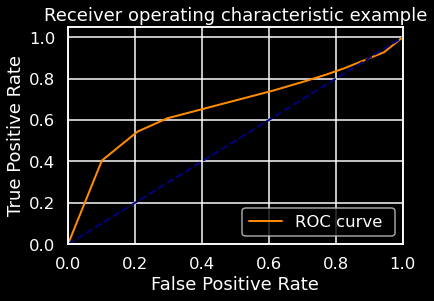

In [12]:
baseline_dict = baseline.copy()
plotAUC(baseline_dict)